# Supervised Learning - Project

In this Project, we are going to perform a full unsupervised learning machine learning project on a "Wholesale Data" dataset. The dataset refers to clients of a wholesale distributor. It includes the annual spending in monetary units (m.u.) on diverse product categories

[Kaggle Link](https://www.kaggle.com/datasets/binovi/wholesale-customers-data-set)

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats.mstats import winsorize
from scipy.cluster.hierarchy import dendrogram, linkage


# Part I : EDA - Exploratory Data Analysis & Pre-processing

The given dataset seems to be a grocery sales dataset containing information about various products sold by a grocery store. To perform an exploratory data analysis (EDA) on this dataset, we can perform the following tasks:

- Data Import: Import the dataset into a statistical software tool such as Python or R.
- Data Cleaning: Check the dataset for any missing or incorrect data and clean the dataset accordingly. This may involve removing or imputing missing data or correcting any obvious errors.
Data Description: Generate summary statistics such as mean, median, and standard deviation for each column of the dataset. This will help in understanding the distribution of data in each column.
- Data Visualization: Create various visualizations such as histograms, box plots, scatter plots, and heatmaps to understand the relationships and trends between the different variables in the dataset. For example, we can create a scatter plot between the "Fresh" and "Milk" variables to see if there is any correlation between them.
- Outlier Detection: Check for any outliers in the dataset and determine whether they are valid or erroneous data points.
- Correlation Analysis: Calculate the correlation between different variables in the dataset to determine which variables are highly correlated and which ones are not. For example, we can calculate the correlation between "Grocery" and "Detergents_Paper" to see if there is any relationship between these two variables.
- Data Transformation: If necessary, transform the data by standardizing or normalizing the variables to make them comparable across different scales.
- Feature Selection: Identify the most important features or variables that contribute the most to the overall variance in the dataset. This can be done using various feature selection techniques such as principal component analysis (PCA) or random forest regression.

### **`Importing Data`**

In [3]:
df = pd.read_csv('Wholesale_Data.csv')

df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [4]:
# Lets get the shape of the dataset

df.shape

(440, 8)

### **`Missing Values?`**

In [5]:
# Scouting for missing values

missing_values = df.isnull().sum()

missing_values

# No missing values thankfully..

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

### **`Initial General Statistics`**

In [6]:
# Looking at some general statistics

df.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


### **`Distribution of Features`**

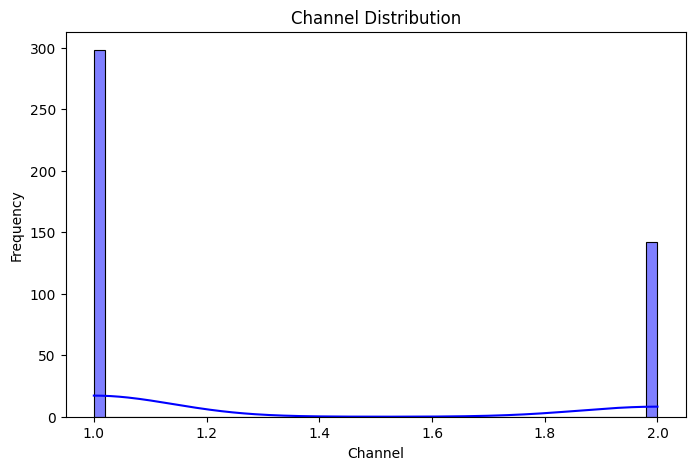

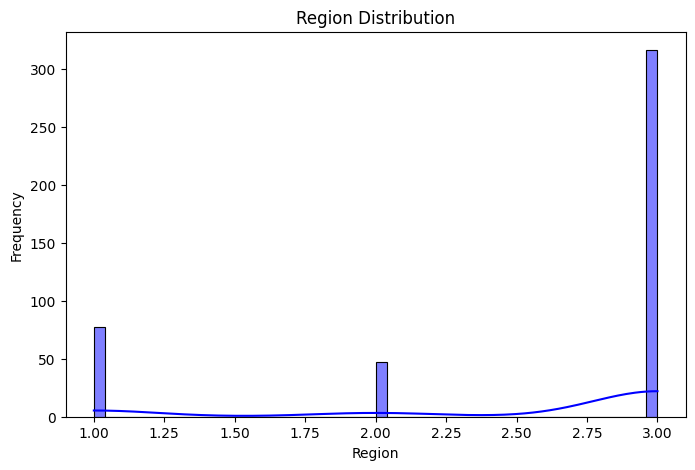

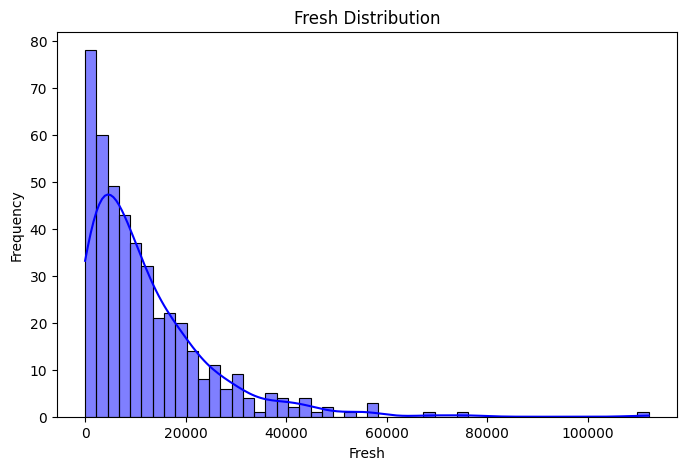

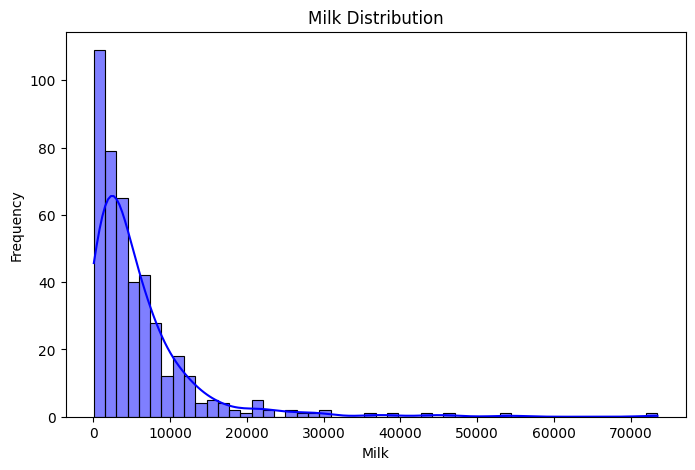

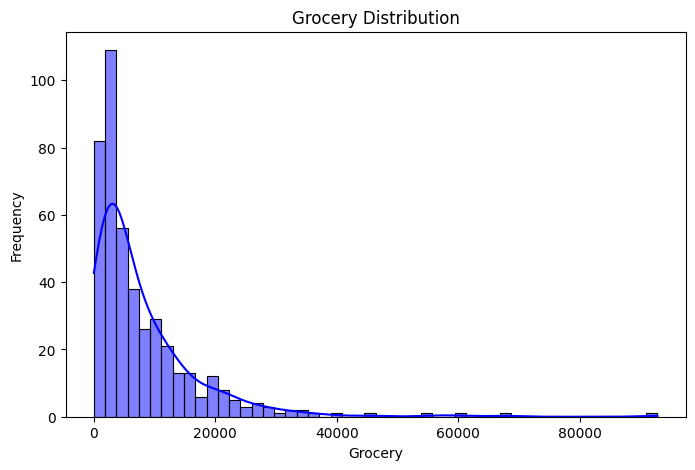

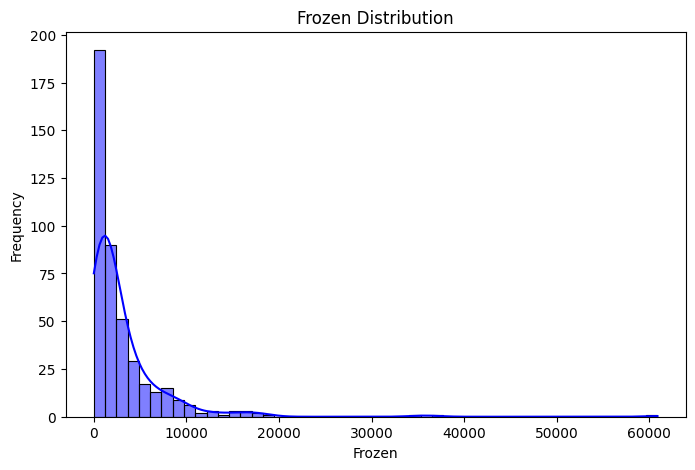

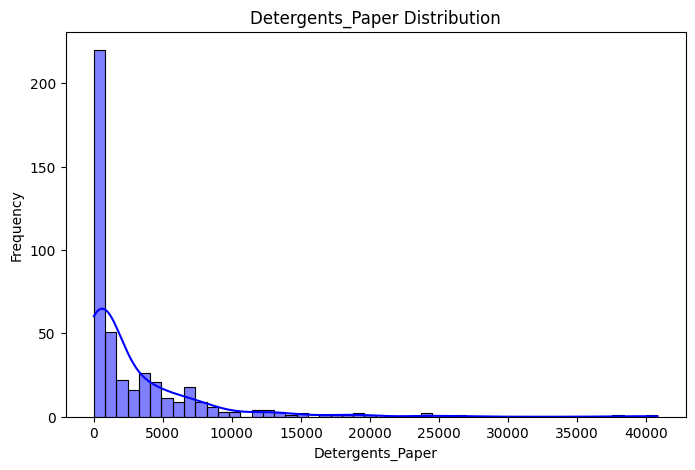

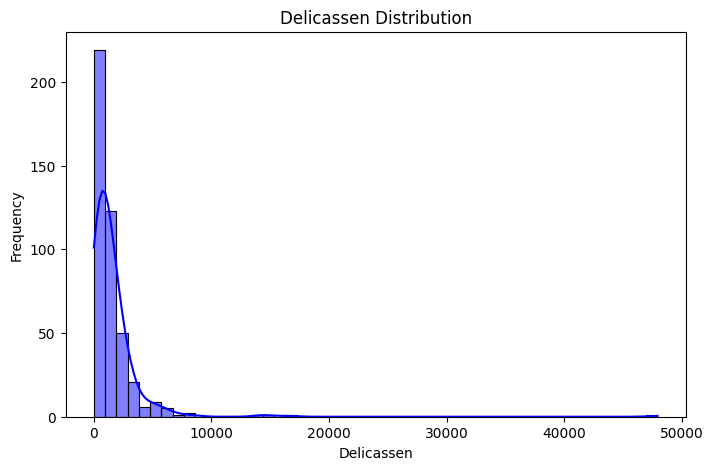

In [7]:
# Let's have a look at the distributions of all features:

for column in df.columns:
    plt.figure(figsize=(8,5))
    sns.histplot(df[column], bins=50, kde=True, color='blue')
    plt.title(f'{column} Distribution')
    plt.xlabel(f'{column}')
    plt.ylabel(f'Frequency')
    plt.show()

It seems like most the features are heavily skewed to the right, lets have a look at outliers and perhaps get rid of any. After that we'll look at distributions again.

Should note that Channel and Region distribution are not continuous in nature and only have 2 and 3 unique values, respectively. That being said, an imbalance in both features can be seen.

### **`Observing Potential Outliers`**

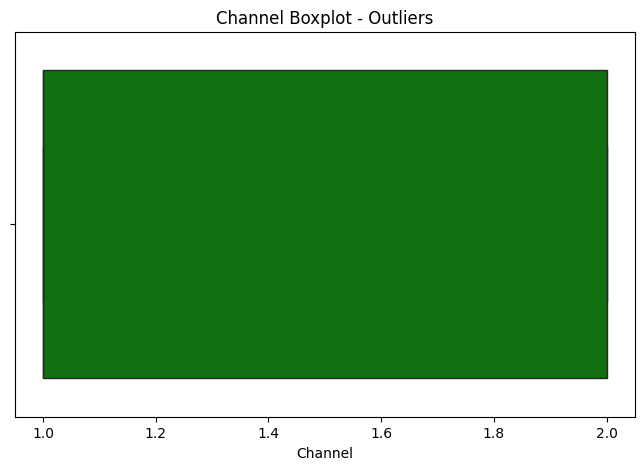

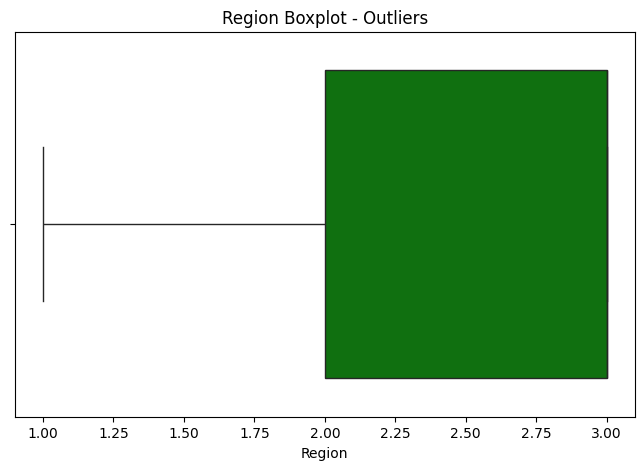

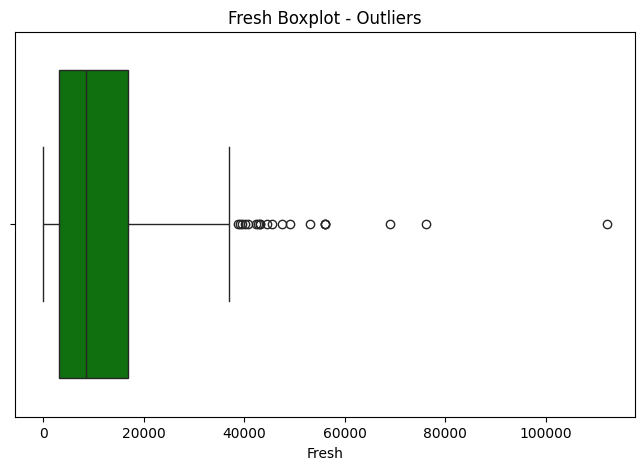

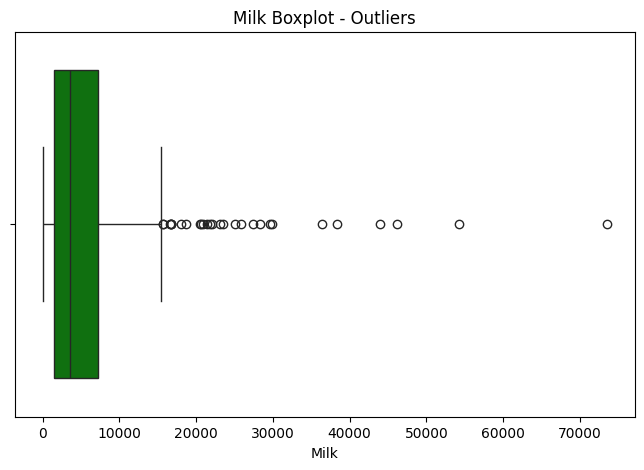

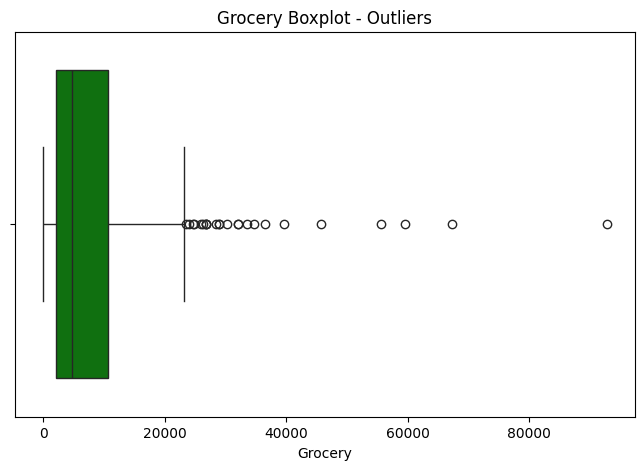

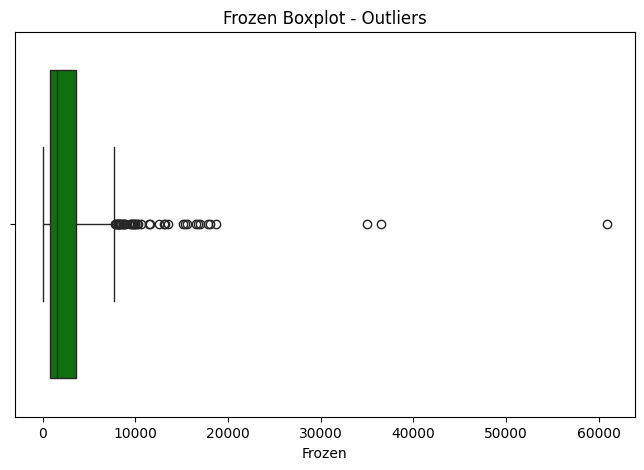

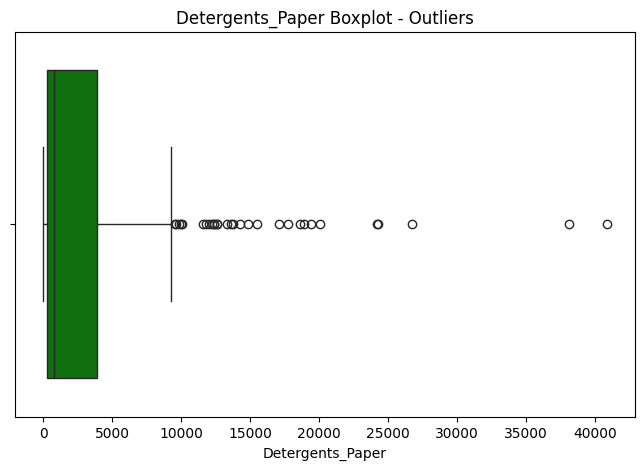

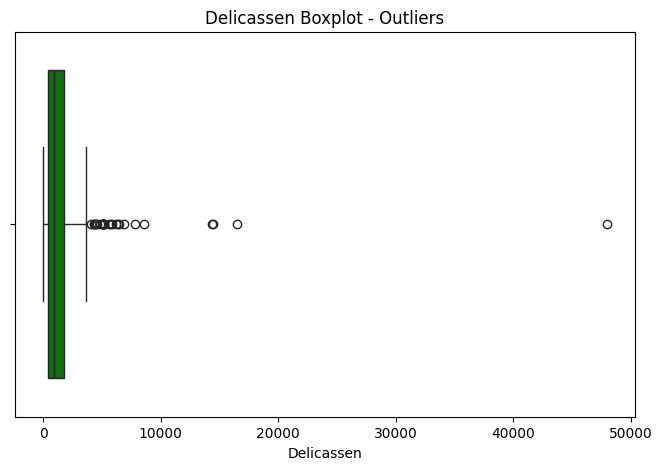

In [8]:
# Box plots to detect outliers

for column in df.columns:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=df[column], color='green')
    plt.title(f'{column} Boxplot - Outliers')
    plt.xlabel(column)
    plt.show()

Quite a lot of outliers for all features (expect channel and region distribution).

we're going to use winsorize - this handles outliers by selecting trimming percentages and in our case the top 1%
and bottom 1% of values will be replaced with values closer to the mean. 

We'll do this for all columns other than channel and region distribution.

### **`Correlation Matrix`**

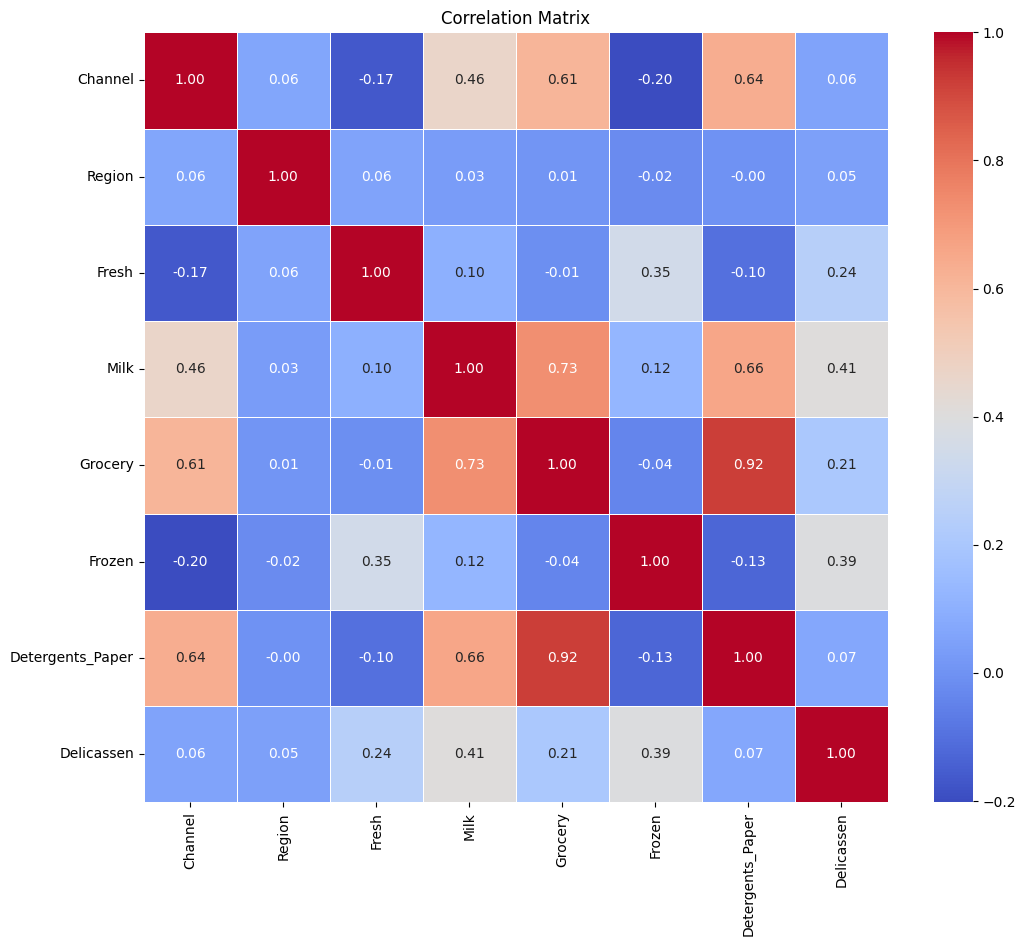

In [9]:
# Let's see a correlation matrix - this might be telling of what features are related with one another
corr_matrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

We can see several highly correlated features:

* Channel Distribution & Grocery = 0.61
* Channel Distribution & Detergents_Paper = 0.64
* Milk & Grocery = 0.73
* Milk & Detergents_Paper = 0.66
* Grocery & Detergents_Paper = 0.92 (very much correlated)

These high correlations, especially the last one may inform on the subsequent PCA process and how many n_components we chose.

### **`Removing Outliers`**

As mentioned above, we're going to cut the top and bottom 8% of data and replace the values with ones closer to the mean. We'll use winzorise to do so.

Note: we're only going to use columns other than channel and region distribution

In [10]:
columns = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']

for column in columns:
    df[column] = winsorize(df[column], limits=[0.08, 0.08])

Let's see how the boxplots have changed:

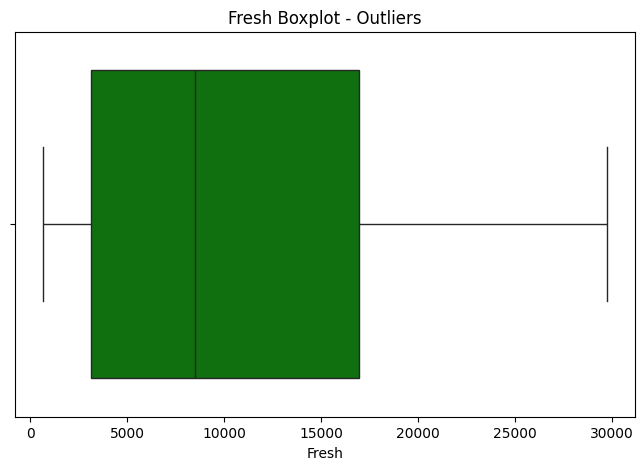

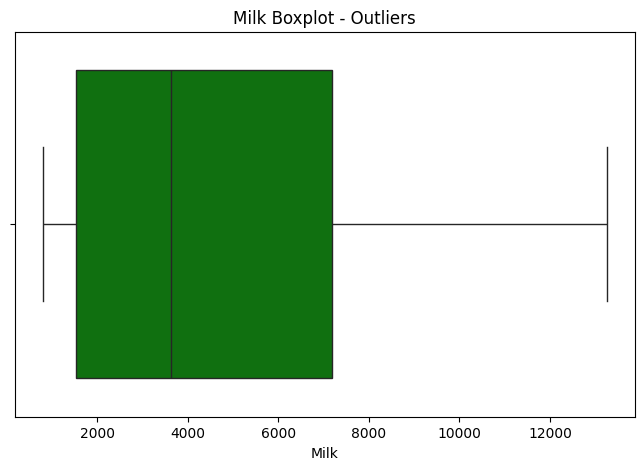

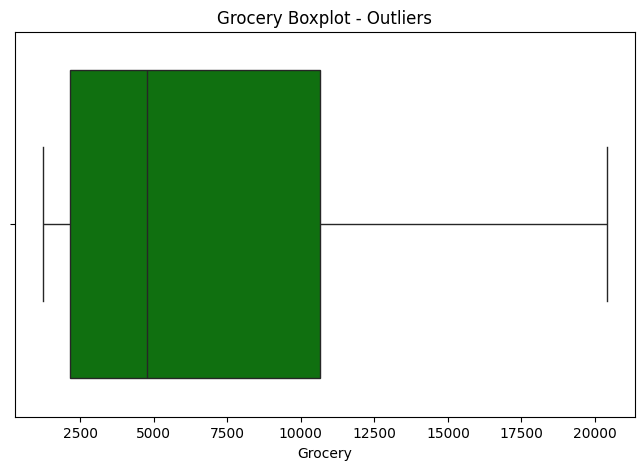

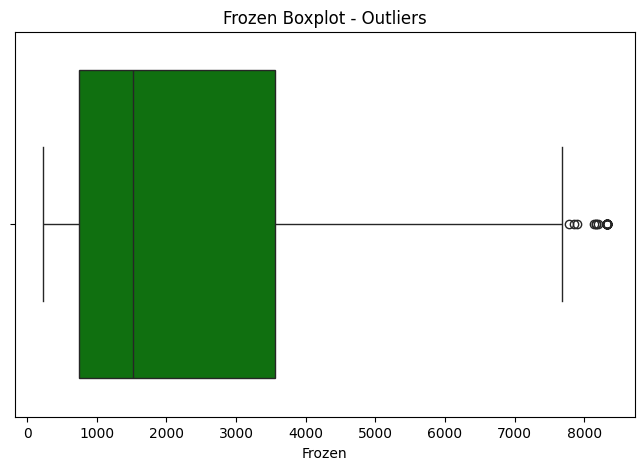

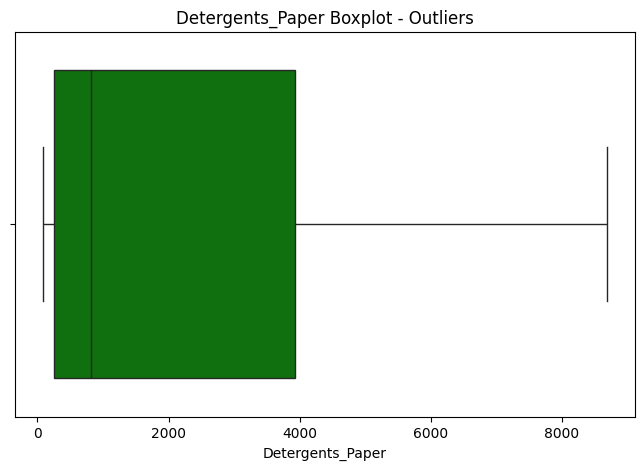

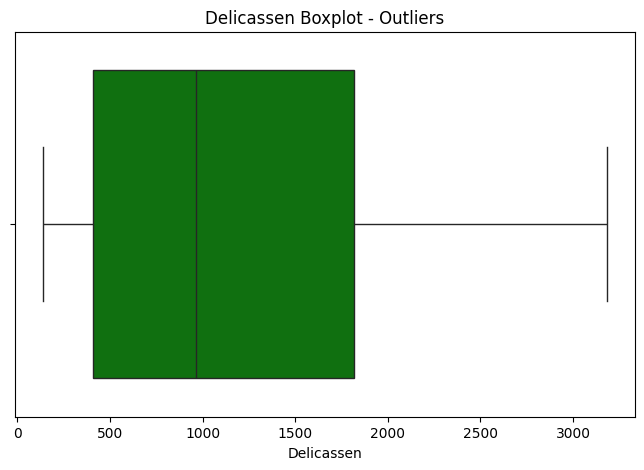

In [11]:
for column in columns:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=df[column], color='green')
    plt.title(f'{column} Boxplot - Outliers')
    plt.xlabel(column)
    plt.show()

### **`Scaling & Normalization`**

Before feeding values into any models/algorithms, we need to scale values to ensure they are of the same... scales.

We can see from produing the descriptive statistics again that features are of different scales.

In [12]:
df.describe()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' of

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,10907.518182,4898.331818,7080.415909,2564.654545,2342.547727,1221.540909
std,0.468052,0.774272,9073.422895,3964.472462,6093.544299,2509.680841,2814.541338,959.400429
min,1.000000,1.000000,660.000000,803.000000,1235.000000,230.000000,86.000000,139.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,29729.000000,13252.000000,20399.000000,8321.000000,8682.000000,3182.000000


In [13]:
scaler = StandardScaler()

numeric_cols = ['Channel', 'Region', 'Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

Let's now see the first few rows of the dataframe

In [14]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,1.448652,0.590668,0.194357,1.201442,0.078958,-0.931318,0.117898,0.121526
1,1.448652,0.590668,-0.424856,1.240331,0.408697,-0.320187,0.338078,0.578580
2,1.448652,0.590668,-0.502534,0.987299,0.099166,-0.063688,0.417399,2.045747
3,-0.690297,0.590668,0.260119,-0.934941,-0.469787,1.531556,-0.652908,0.591102
4,1.448652,0.590668,1.291774,0.129210,0.019318,0.538667,-0.201167,2.045747


# Part II - KMeans Clustering

The objective of the analysis is to group similar products together into clusters based on their attributes such as fresh, milk, grocery, frozen, detergents_paper, and delicatessen. To perform the k-means clustering analysis, you will need to pre-process the dataset, determine the optimal number of clusters, initialize the centroids, assign data points to clusters, update the centroids, and repeat until convergence.

### **`Looking at Products only`**

In [15]:
# Selecting our features

features = df[['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']]


### **`Elbow Method - Optimal Clusters`**

In [16]:
inertia = []

for i in range(1, 11):
    k_means = KMeans(n_clusters=i, random_state=0)
    k_means.fit(features)
    inertia.append(k_means.inertia_)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.1

Lets graph the output:

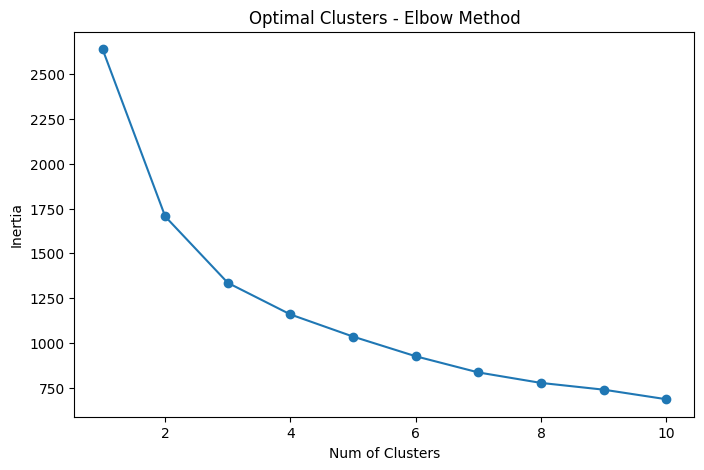

In [17]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Optimal Clusters - Elbow Method')
plt.xlabel('Num of Clusters')
plt.ylabel('Inertia')
plt.show()

It's quite tough to come down to a single figure here however, based on judgement, it appears that K = 6 is good value to go forward with - subsequent values dont really show much of a change in the slope so let's run with 6. 

We can always come back to adjust.

In [18]:
optimal_k = 6

### **`Fitting KMeans`**

In [19]:
kmeans = KMeans(n_clusters=6, init='k-means++', max_iter=300, n_init=10, random_state=0)
df['Cluster'] = kmeans.fit_predict(features)


# Part III - Hierarchical Clustering 

Hierarchical clustering is a popular unsupervised machine learning algorithm that is used to identify patterns and group similar data points together in a hierarchy. The algorithm works by iteratively merging or splitting clusters based on a similarity measure until a dendrogram is formed.

To perform hierarchical clustering analysis, you will need to pre-process the dataset, determine the optimal number of clusters using techniques such as dendrogram.

### **`Dendrogram`**

We'll be considering the same set of features as used in KMeans above and we've already preprocessed the data (did it before Kmeans).

As before, we're not including channel and region as they are categorical features, in addition, if were trying to look at spending patterns/behaviours of consumers, its best to focus on the products.

In [20]:
features

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,0.194357,1.201442,0.078958,-0.931318,0.117898,0.121526
1,-0.424856,1.240331,0.408697,-0.320187,0.338078,0.578580
2,-0.502534,0.987299,0.099166,-0.063688,0.417399,2.045747
3,0.260119,-0.934941,-0.469787,1.531556,-0.652908,0.591102
4,1.291774,0.129210,0.019318,0.538667,-0.201167,2.045747
...,...,...,...,...,...,...
435,2.073845,1.806245,1.469878,2.296267,-0.768511,1.025200
436,2.076714,-0.875597,-0.960372,0.776019,-0.800169,1.173378
437,0.399806,2.109531,2.188176,-0.848744,2.254957,0.673539
438,-0.068135,-0.736706,-0.796570,-0.608999,-0.773491,0.942763


In [21]:
linkage_matrix = linkage(features, method='ward') # setting method to ward for Agglomerative Clustering

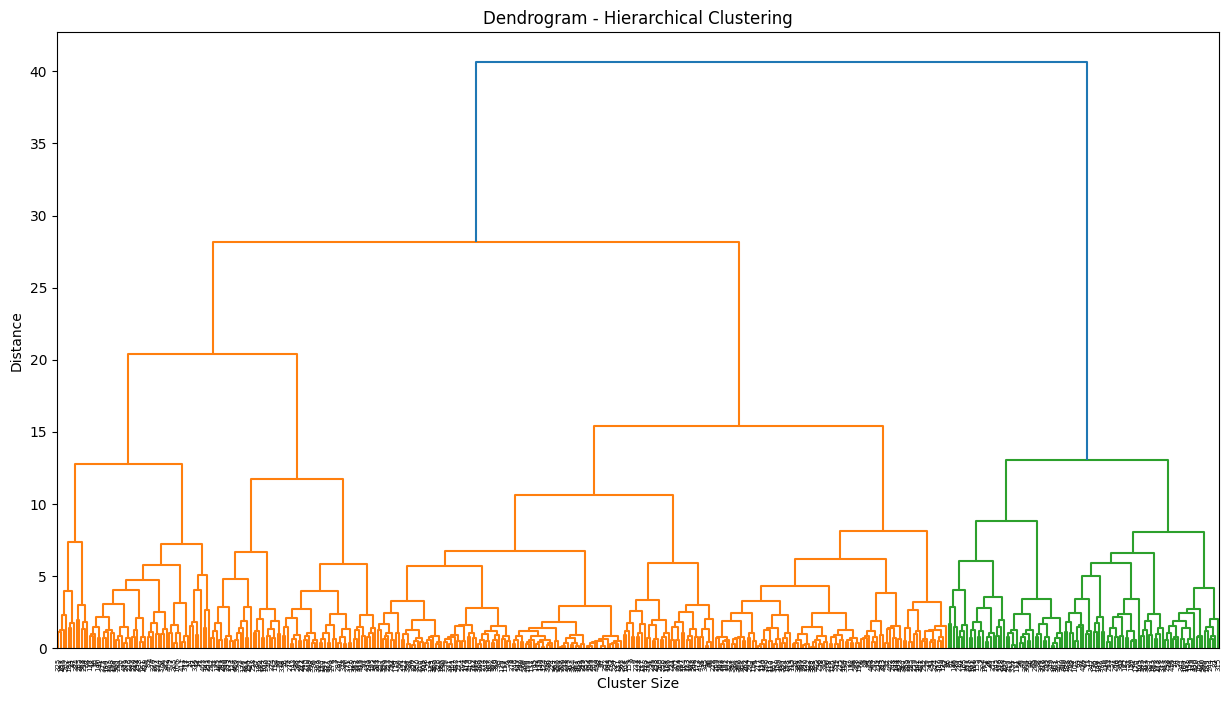

In [22]:
# Lets have a look at our dendrogram
plt.figure(figsize=(15, 8))
dendrogram(linkage_matrix, orientation='top', labels=df.index, distance_sort='descending', show_leaf_counts=True)
plt.title('Dendrogram - Hierarchical Clustering')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.show()

# Part IV - PCA

In this section you are going to perform principal component analysis (PCA) to draw conclusions about the underlying structure of the wholesale customer data. Since using PCA on a dataset calculates the dimensions which best maximize variance, we will find which compound combinations of features best describe customers.

### **`PCA and Explaind Variance Ratio`**

In [38]:
# Out features again
features

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,0.194357,1.201442,0.078958,-0.931318,0.117898,0.121526
1,-0.424856,1.240331,0.408697,-0.320187,0.338078,0.578580
2,-0.502534,0.987299,0.099166,-0.063688,0.417399,2.045747
3,0.260119,-0.934941,-0.469787,1.531556,-0.652908,0.591102
4,1.291774,0.129210,0.019318,0.538667,-0.201167,2.045747
...,...,...,...,...,...,...
435,2.073845,1.806245,1.469878,2.296267,-0.768511,1.025200
436,2.076714,-0.875597,-0.960372,0.776019,-0.800169,1.173378
437,0.399806,2.109531,2.188176,-0.848744,2.254957,0.673539
438,-0.068135,-0.736706,-0.796570,-0.608999,-0.773491,0.942763


Fitting Principal Compnents Analysis on standardised features

In [39]:
pca = PCA(n_components=None)

princ_comp = pca.fit_transform(features)

Let's plot the results of the above

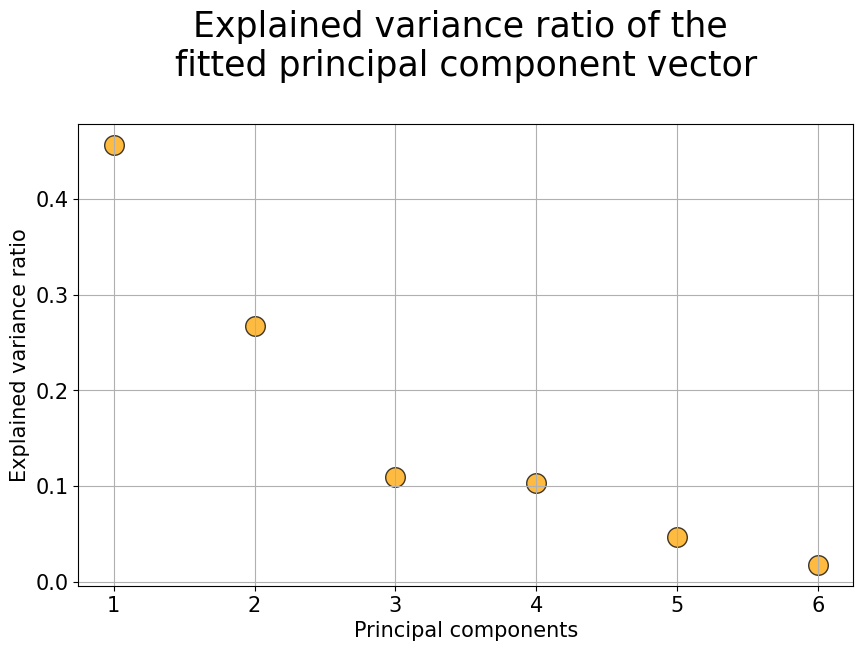

In [40]:
plt.figure(figsize=(10,6))
plt.scatter(x=[i+1 for i in range(len(pca.explained_variance_ratio_))],
            y=pca.explained_variance_ratio_,
            s=200, alpha=0.75, c='orange', edgecolor='k')
plt.grid(True)
plt.title("Explained variance ratio of the \nfitted principal component vector\n", fontsize=25)
plt.xlabel("Principal components", fontsize=15)
plt.xticks([i+1 for i in range(len(pca.explained_variance_ratio_))], fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Explained variance ratio", fontsize=15)
plt.show()

In [41]:
pca.explained_variance_ratio_

array([0.45663407, 0.26721726, 0.10892985, 0.10279562, 0.04681584,
       0.01760736])

As seen direcetly above and the plot, the first two componenets provided the most explained varaiance with 45.6% of the variance and the second component with 26.7% explained variances and together, 72.3%!

This should inform on n_components, where 2 seems like a good value to go with.

### **`Plotting Both Principal Components`**

We can also seperate them by the 3 regions (or the 2 channels)

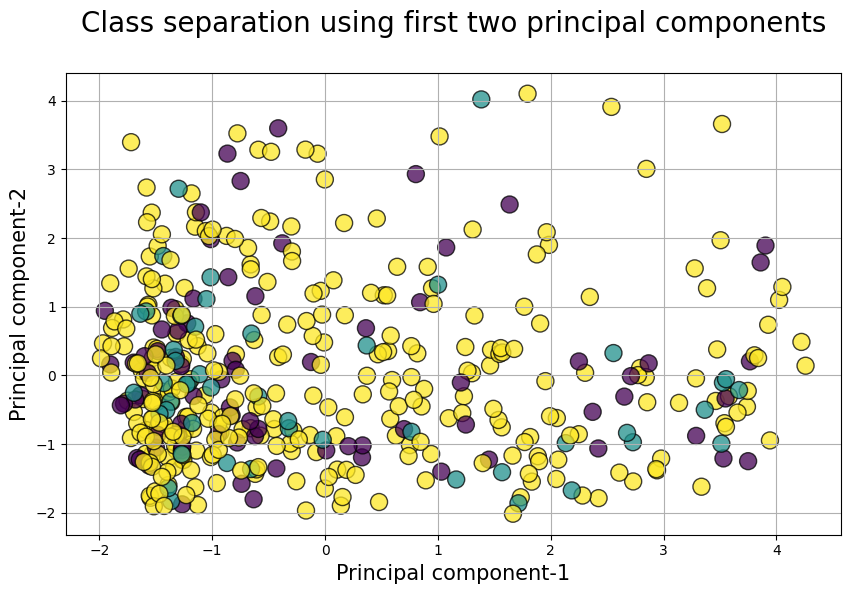

In [49]:
df_trans = pca.transform(features)
df_trans = pd.DataFrame(data=df_trans, columns=['Principal Component 1', 'Principal Component 2', 'Principal Component 3', 'Principal Component 4', 'Principal Component 5', 'Principal Component 6'])

plt.figure(figsize=(10,6))
plt.scatter(df_trans['Principal Component 1'],df_trans['Principal Component 2'],c=df['Region'],edgecolors='k',alpha=0.75,s=150)
plt.grid(True)
plt.title("Class separation using first two principal components\n",fontsize=20)
plt.xlabel("Principal component-1",fontsize=15)
plt.ylabel("Principal component-2",fontsize=15)
plt.show()

# Part V - Conclusion

From the model you developed and the exploratory data analysis (EDA) conducted, generate four bullet points as your findings.

* Despite having 6 original columns, through our PCA process it was seen that 2 prinicpal components best explain more specifically, 72.3% of the variation.
* 6 clusters was the most optimal for KMeans - while we could have selected values like 8 or 10, the difference in inertia was minimal/negligable
* Much of the features (excluding channel and region) had many outliers and using winsorize to replace top and bottom% of data with values closer to the mean, we had chosen 8% which is quite a large number
* Grocery and Detergents_paper are very highly correlated with a value of 0.92, so could that result in multicolinearity?